In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gp import *
from data_loader import data_loader
import time

In [2]:
filename = 'trajectory.pkl'
compute_reduction = 10
n_training_samples = 100

d_loader = data_loader(filename, compute_reduction, n_training_samples)               

v_display = d_loader.get_z(training=False)[:,7:10]
y_display = d_loader.get_y(training=False)
a_validation = d_loader.get_a_validation()

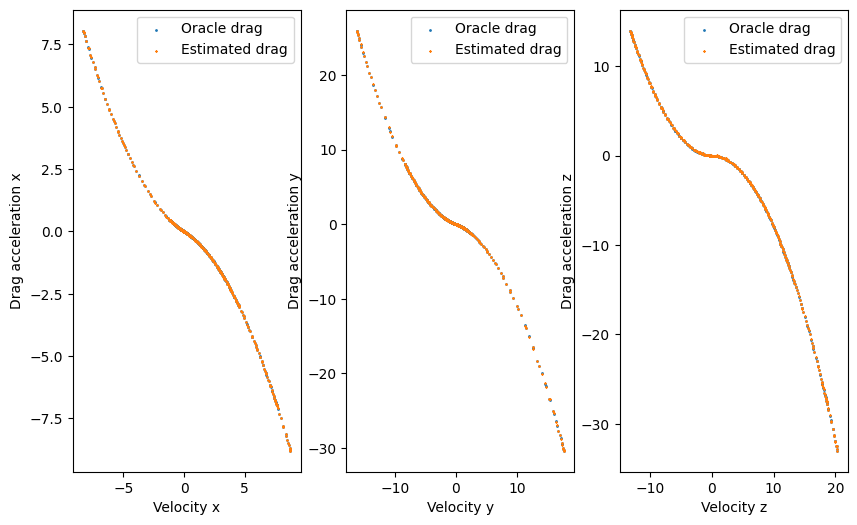

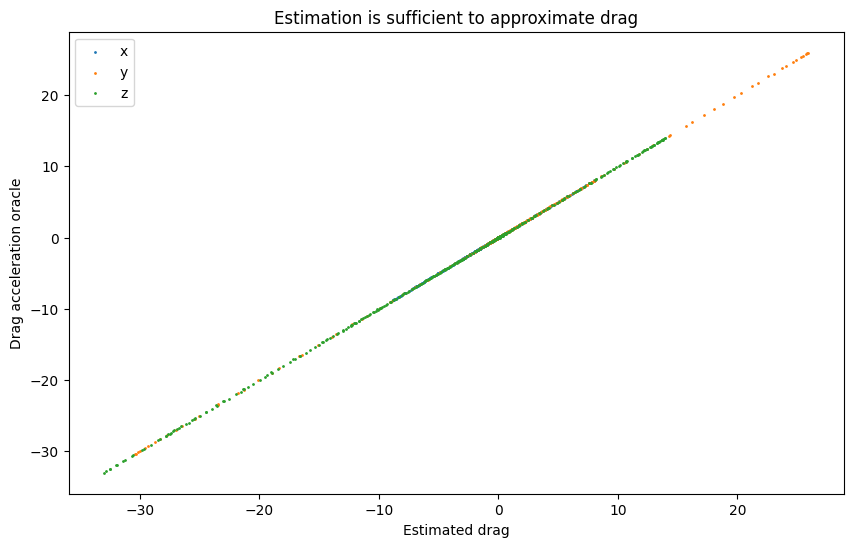

In [3]:
plt.figure(figsize=(10, 6), dpi=100)
plt.subplot(131)
plt.scatter(v_display[:,0], a_validation[:,0],s=1)
plt.scatter(v_display[:,0], y_display[:,0], marker='x',s=1)
plt.xlabel('Velocity x')
plt.ylabel('Drag acceleration x')
plt.legend(('Oracle drag', 'Estimated drag'))
plt.subplot(132)
plt.scatter(v_display[:,1], a_validation[:,1],s=1)
plt.scatter(v_display[:,1], y_display[:,1], marker='x',s=1)
plt.xlabel('Velocity y')
plt.ylabel('Drag acceleration y')
plt.legend(('Oracle drag', 'Estimated drag'))
plt.subplot(133)
plt.scatter(v_display[:,2], a_validation[:,2],s=1)
plt.scatter(v_display[:,2], y_display[:,2], marker='x',s=1)
plt.xlabel('Velocity z')
plt.ylabel('Drag acceleration z')
plt.legend(('Oracle drag', 'Estimated drag'))



plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(y_display[:,0], a_validation[:,0],s=1)
plt.scatter(y_display[:,1], a_validation[:,1],s=1)
plt.scatter(y_display[:,2], a_validation[:,2],s=1)
plt.xlabel('Estimated drag')
plt.ylabel('Drag acceleration oracle')
plt.title('Estimation is sufficient to approximate drag')
plt.legend(('x', 'y', 'z'))

In [4]:
d_loader.shuffle()

z = d_loader.get_z(training=False)
y = d_loader.get_y(training=False)


z_train = d_loader.get_z(training=True)
y_train = d_loader.get_y(training=True)

# x velocity
z_x_train = z_train[:,7].reshape(-1,1)
z_x = z[:,7].reshape(-1,1)

y_x_train = y_train[:,0].reshape(-1,1)
y_x = y[:,0].reshape(-1,1)

In [5]:
theta0 = [1,1,1] # Kernel variables
x_query = np.arange(-15,15,0.05).reshape(-1,1)

model = GPR(z_x_train, y_x_train, covariance_function=RBF, theta=theta0)
# Before ML optimization
mean_b, std_b = model.predict(x_query, std=True)
mean_test_before = model.predict(z_x, std=False)
rms_before = np.sqrt(np.mean((y_x - mean_test_before)**2))

# ML optimization
t = time.time()
model.maximize_likelyhood()
print(f'Elapsed time = {time.time() - t}')
# After optimization
mean_a, std_a = model.predict(x_query, std=True)

mean_test_after = model.predict(z_x, std=False)
rms_after = np.sqrt(np.mean((y_x - mean_test_after)**2))

print(f'RMS before = {rms_before}')
print(f'RMS after = {rms_after}')

Size of feature training data = (100, 1)
Size of output training data = (100, 1)
Maximizing the likelyhood function for GP
Hyperparameters before optimization = [1, 1, 1]
Size of feature training data = (100, 1)
Size of output training data = (100, 1)
Optimization done
Hyperparameters after optimization = [7.37157375 8.33225372 0.1       ]
Elapsed time = 17.109643936157227
RMS before = 1.0657355762871557
RMS after = 0.06191050446751983


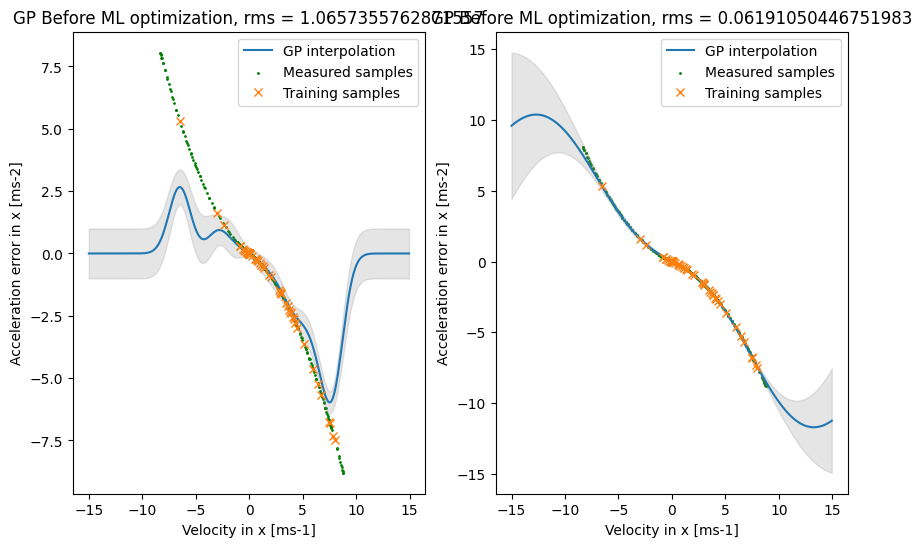

In [6]:
plt.figure(figsize=(10,6), dpi=100)
plt.subplot(1,2,1)
plt.plot(x_query, mean_b)
plt.scatter(z_x, y_x, s=1, c='g')
plt.plot(z_x_train, y_x_train, 'x')
plt.fill_between(x_query.reshape(-1), mean_b.reshape(-1) - std_b, mean_b.reshape(-1) + std_b,
                 color='gray', alpha=0.2)
plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title(f'GP Before ML optimization, rms = {rms_before}')
plt.legend(('GP interpolation', 'Measured samples', 'Training samples'))


plt.subplot(1,2,2)
plt.plot(x_query, mean_a)
plt.scatter(z_x, y_x, s=1, c='g')
plt.plot(z_x_train, y_x_train, 'x')
plt.fill_between(x_query.reshape(-1), mean_a.reshape(-1) - std_a, mean_a.reshape(-1) + std_a,
                 color='gray', alpha=0.2)
plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title(f'GP Before ML optimization, rms = {rms_after}')
plt.legend(('GP interpolation', 'Measured samples', 'Training samples'))